In [12]:
import numpy as np
import scipy.stats as stat
import matplotlib.pyplot as plot
import statsmodels.api as sm

In [13]:
data = np.loadtxt("data.txt")
data = np.concatenate(data)
data = np.array(sorted(data))

# 1. sample characteristics

In [18]:
n = np.size(data)
mean = np.mean(data)
var = np.var(data)
kurtosis = stat.kurtosis(data, bias=False)
skewness = stat.skew(data, bias=True)

print(f"mean: {mean}")
print(f"variation: {var}")
print(f"kurtosis: {kurtosis}")
print(f"skewness: {skewness}")
print(f"size: {n}")

mean: -1.100377148133333
variation: 1.8506794964312567
kurtosis: -0.5721080838991606
skewness: -0.21527923156203657
size: 60


In [17]:
def kurt(x):
    m = np.mean(x)
    n = np.size(x)
    k2 = np.var(x) * n / (n - 1)
    
    return (n+1) * n / ((n - 1) * (n - 2) * (n - 3)) * np.sum((x-m)**4) / k2**2 - 3 * (n - 1)**2 / ((n - 2) * (n - 3))
def skew(x):
    m = np.mean(x)
    n = np.size(x)
    k2 = np.var(x) * n / (n - 1)
    return n / ((n - 1) * (n - 2) ) * np.sum((x-m)**3) / k2**1.5 
print(skew(data))
print(kurt(data))

-0.22083900004591922
-0.5721080838991597


# 2. histogramm and sample cdf

Text(0.5, 1.0, 'histogramm')

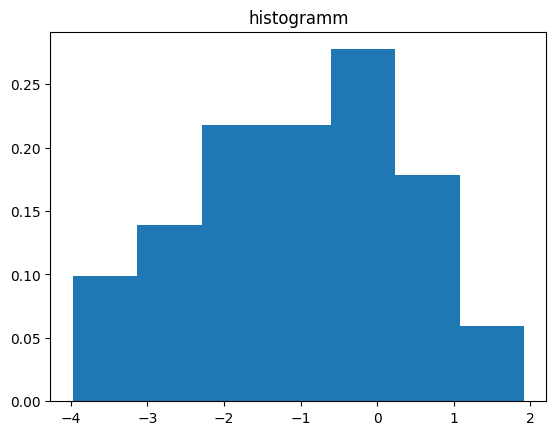

In [47]:
bins = 7

fig, ax = plot.subplots()
ax.hist(data, density=True, bins=7)
plot.title("histogramm")


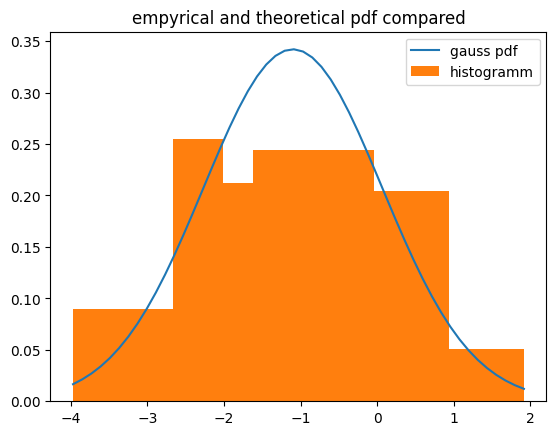

In [66]:
gr[1] = (gr[2] - gr[1]) * 1/3 + gr[1]
# gr[3] = (gr[3] - gr[2]) * 2/3 + gr[2]
fig, ax = plot.subplots()
x = np.linspace(min(data), max(data), 50)
ax.plot(x, stat.norm.pdf(x, loc=ml_exp, scale=ml_var**0.5))
ax.hist(data, density=True, bins=gr)
plot.title("empyrical and theoretical pdf compared")
plot.legend(["gauss pdf", "histogramm"])

# plot.hist(data, density=True, bins=gr)

Text(0.5, 1.0, 'empirical cdf')

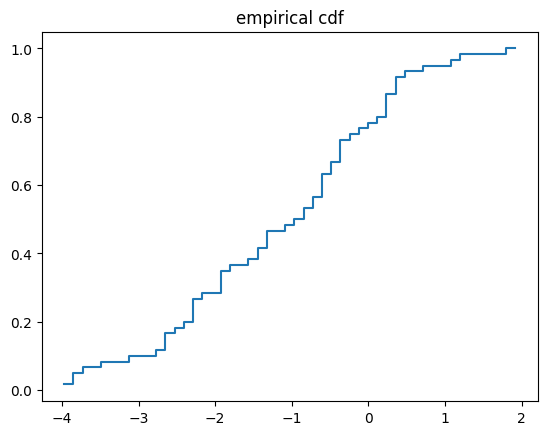

In [20]:
ecdf = sm.distributions.ECDF(data)
x = np.linspace(min(data), max(data))
y = ecdf(x)
plot.step(x, y)
plot.title("empirical cdf")

# 3. gamma confidence interval for cdf

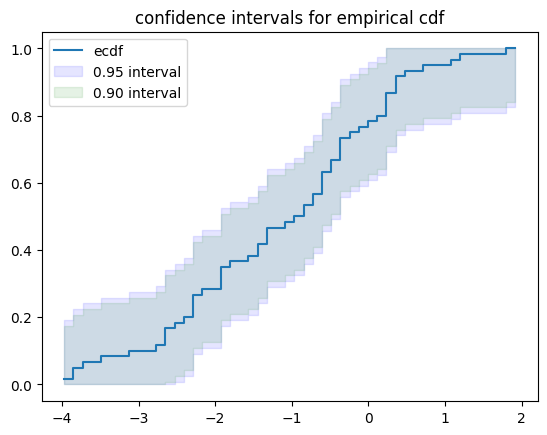

In [21]:
lower_bound = lambda x, perc: ecdf(x) - stat.kstwobign.ppf(perc) / n**0.5
upper_bound = lambda x, perc: ecdf(x) + stat.kstwobign.ppf(perc) / n**0.5


x = np.linspace(min(data), max(data))
y = ecdf(x)
lb_95 = np.maximum(lower_bound(x, 0.95), np.zeros(np.size(x)))
ub_95 = np.minimum(upper_bound(x, 0.95), np.ones(np.size(x)))
lb_90 = np.maximum(lower_bound(x, 0.90), np.zeros(np.size(x)))
ub_90 = np.minimum(upper_bound(x, 0.90), np.ones(np.size(x)))


fig, ax = plot.subplots()
ax.step(x,y)
ax.fill_between(x, lb_95, ub_95, color='b', alpha=.1, step="pre")
ax.fill_between(x, lb_90, ub_90, color='g', alpha=.1, step="pre")
plot.title("confidence intervals for empirical cdf")
plot.legend(["ecdf", "0.95 interval", "0.90 interval"])

# 4-5 Chi square test
looks like normal distribution - try it

$X_n = \sum (O_i - E_i)^2 / E_i$, 

$O_i$ - number of observed instances in i-th interval, $E_i$ - expected instances in i-th interval 

In [28]:
# split data into intervals of same length s.t. each of its length is approximately 1
# (cuz O_i must be more than 5 and such length allows it, looking at histogramm)
def calc_obs(sample, grid):
    obs = np.zeros(np.size(grid) - 1)
    for val in sample:
        for i in range(np.size(grid) - 1):
            obs[i] = obs[i] + 1 if grid[i] <= val <= grid[i+1] else obs[i]
    return obs

def calc_exp_norm(grid, param, n=n):
    N = np.size(grid) - 1
    exp = np.zeros(N)
    for i in range(N):
        lb = grid[i]
        ub = grid[i+1]
        exp[i] = (stat.norm.cdf(ub, loc=param[0], scale=param[1]) - stat.norm.cdf(lb, loc=param[0], scale=param[1])) * n
    return exp

def calc_grid(x, interval_length=1):
    max = np.max(x)
    min = np.min(x)
    grid = np.linspace(min, max, num=int((max - min) // interval_length + 1))
    a, b = grid[-3], grid[-2]
    grid[-2] = (b - a) * 2/3 + a
    return grid
    
def calc_chi_square_stat(obs, exp):
    return np.sum((obs - exp)**2 / exp)  

def chi_square_stat(param):
    grid = calc_grid(data)
    obs = calc_obs(data, grid)
    exp = calc_exp_norm(grid, param)
    return calc_chi_square_stat(obs,exp)  


from scipy.optimize import minimize
opt_param_norm = minimize(chi_square_stat, [mean, var**0.5]).x
grid = calc_grid(data)
exp = calc_exp_norm(grid, opt_param_norm)
obs = calc_obs(data, grid)

print("GAUSS DISTRIBUTION TEST")
print(f"opt_param_norm: {opt_param_norm}")
print(f"obs: {obs}")
print(f"exp: {exp}")

chi_sq_stat_value = calc_chi_square_stat(obs, exp)
df = np.size(obs) - np.size(opt_param_norm) - 1
quantile_chi2 = stat.chi2.ppf(0.95, df=df)
p_value = 1 - stat.chi2.cdf(chi_sq_stat_value, df) 
print(f"chi_sq_stat_value: {chi_sq_stat_value}")
print(f"quantile_chi2: {quantile_chi2}")
print(f"p_value: {p_value}")


GAUSS DISTRIBUTION TEST
opt_param_norm: [-1.06092384  1.42423764]
obs: [ 6. 16. 16. 14.  8.]
exp: [ 5.48721197 14.18609114 19.22655019 10.16840483  8.59826542]
chi_sq_stat_value: 2.306753231842855
quantile_chi2: 5.991464547107979
p_value: 0.31556941166491037


In [30]:
data_shift = data - np.min(data)
def calc_exp_gamma(grid, param, n=n):
    N = np.size(grid) - 1
    exp = np.zeros(N)
    for i in range(N):
        lb = grid[i]
        ub = grid[i+1]
        a = param[0]
        beta = param[1]
        exp[i] = (stat.gamma.cdf(ub, a, scale=1/beta) - stat.gamma.cdf(lb, a, scale=1/beta)) * n
    return exp

def chi_square_stat(param):
    grid = calc_grid(data_shift)
    obs = calc_obs(data_shift, grid)
    exp = calc_exp_gamma(grid, param)
    return calc_chi_square_stat(obs,exp)  

opt_param_gamma = minimize(chi_square_stat, [1, 1], bounds=[(0,None), (0,None)]).x

grid = calc_grid(data_shift)
exp = calc_exp_gamma(grid, opt_param_gamma)
obs = calc_obs(data_shift, grid)


print("GAMMA DISTRIBUTION TEST")
print(f"opt_param_gamma: {opt_param_gamma}")
print(f"obs: {obs}")
print(f"exp: {exp}")

chi_sq_stat_value = calc_chi_square_stat(obs, exp)
df = np.size(obs) - np.size(opt_param_gamma) - 1
quantile_chi2 = stat.chi2.ppf(0.95, df=df)
p_value = 1 - stat.chi2.cdf(chi_sq_stat_value, df) 
print(f"chi_sq_stat_value: {chi_sq_stat_value}")
print(f"quantile_chi2: {quantile_chi2}")
print(f"p_value: {p_value}")

GAMMA DISTRIBUTION TEST
opt_param_gamma: [3.51047783 1.07999569]
obs: [ 6. 16. 16. 14.  8.]
exp: [ 4.50865889 16.37501565 16.98614413  8.20473715  9.11032135]
chi_sq_stat_value: 4.7878309561144645
quantile_chi2: 5.991464547107979
p_value: 0.09127161133095729


In [75]:
# additional goodness of fit tests, just to make sure
p_value_cramer_mises = stat.cramervonmises(data, "norm", args=(opt_param_norm)).pvalue
p_value_kolmogorov_smirnov = stat.ks_1samp(data, stat.norm.cdf, args=(opt_param_norm), alternative="two-sided").pvalue
p_value_shapiro = stat.shapiro(data).pvalue
print(f"p_value_shapiro: {p_value_shapiro}")
print(f"p_value_cramer_mises: {p_value_cramer_mises}")
print(f"p_value_kolmogorov_smirnov: {p_value_kolmogorov_smirnov}")

p_value_shapiro: 0.37330368161201477
p_value_cramer_mises: 0.7968564685561307
p_value_kolmogorov_smirnov: 0.7168541257013336


# 6. calculate maximum likelihood parameter estimation
for normal distribution, sample variance and expectation are ML estimations for variance and expectation accordingly

In [23]:
ml_exp = mean
ml_var = var

# 7. comparisson of sample and theoretical cdf and pdf

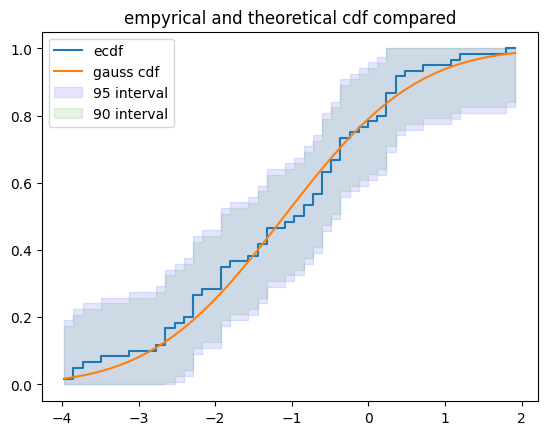

In [25]:
fig, ax = plot.subplots()
ax.step(x,y)
# ax.plot(x, stat.gamma.cdf(x, opt_param_gamma[1], loc=opt_param_gamma[0], scale=1/opt_param_gamma[2]))
ax.plot(x, stat.norm.cdf(x, loc=ml_exp, scale=ml_var**0.5))
ax.fill_between(x, lb_95, ub_95, color='b', alpha=.1, step="pre")
ax.fill_between(x, lb_90, ub_90, color='g', alpha=.1, step="pre")
plot.title("empyrical and theoretical cdf compared")
plot.legend(["ecdf", "gauss cdf", "95 interval", "90 interval"])

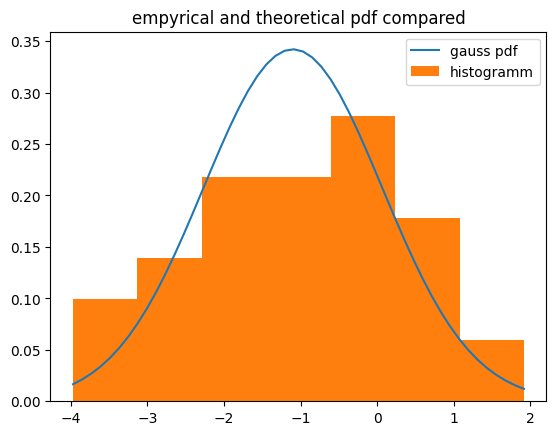

In [26]:
fig, ax = plot.subplots()
ax.plot(x, stat.norm.pdf(x, loc=ml_exp, scale=ml_var**0.5))
ax.hist(data, density=True, bins=7)
plot.title("empyrical and theoretical pdf compared")
plot.legend(["gauss pdf", "histogramm"])